# **About Dataset**

This dataset contains historical daily prices for all tickers currently trading on NASDAQ. It contains prices for up to 01 of April 2020. If you need more up to date data, just fork and re-run data collection script also available from Kaggle.All that ticker data is then stored in either ETFs or stocks folder, depending on a type. Moreover, each filename is the corresponding ticker symbol. At last, symbols_valid_meta.csv contains some additional metadata for each ticker such as full name.

# **Data Gathering**

In [1]:
# Import Libraries
import os
import warnings
warnings.filterwarnings('ignore')
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
# Load Dataset
base_df = '/kaggle/input/stock-market-dataset'

In [3]:
etf = os.path.join(base_df, "etfs")
stocks = os.path.join(base_df, "stocks")

In [5]:
apple = pd.read_csv('stocks/AAPL.csv')

In [6]:
apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


In [7]:
# Getting an overview of the features and their types in the Apple Stock data
print("Overview of the features and their types:")
apple.info()

Overview of the features and their types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9909 entries, 0 to 9908
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9909 non-null   object 
 1   Open       9909 non-null   float64
 2   High       9909 non-null   float64
 3   Low        9909 non-null   float64
 4   Close      9909 non-null   float64
 5   Adj Close  9909 non-null   float64
 6   Volume     9909 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 542.0+ KB


> All features are Numerical, except Date is object

In [8]:
# Check for missing values
apple.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
apple['Date'].value_counts()

Date
1980-12-12    1
2007-02-23    1
2007-02-13    1
2007-02-14    1
2007-02-15    1
             ..
1994-01-07    1
1994-01-10    1
1994-01-11    1
1994-01-12    1
2020-04-01    1
Name: count, Length: 9909, dtype: int64

In [10]:
# Check for unique dates
apple['Date'].unique

<bound method Series.unique of 0       1980-12-12
1       1980-12-15
2       1980-12-16
3       1980-12-17
4       1980-12-18
           ...    
9904    2020-03-26
9905    2020-03-27
9906    2020-03-30
9907    2020-03-31
9908    2020-04-01
Name: Date, Length: 9909, dtype: object>

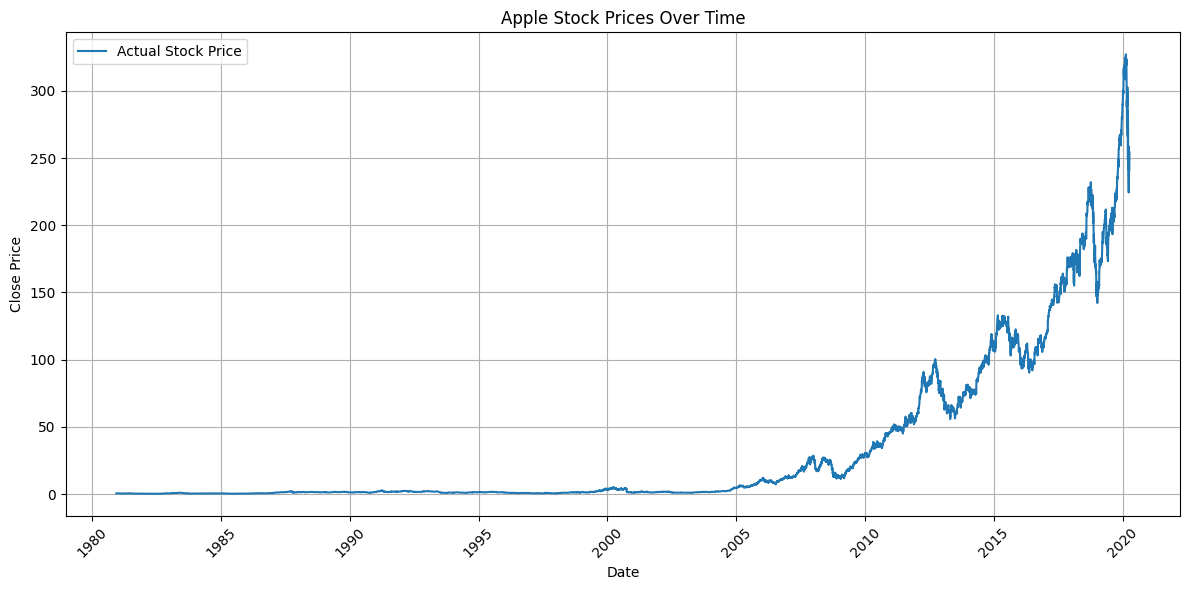

In [11]:
apple['Date'] = pd.to_datetime(apple['Date'])

# Plot the actual 'Close' prices over time
plt.figure(figsize=(12, 6))
plt.plot(apple['Date'], apple['Close'], label='Actual Stock Price')
plt.title('Apple Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
apple['Date'] = pd.to_datetime(apple['Date'])

# Extract the month from the 'Date' column
apple['Month'] = apple['Date'].dt.month

apple[['Date', 'Month']].head()

,Date,Month
0,1980-12-12,12
1,1980-12-15,12
2,1980-12-16,12
3,1980-12-17,12
4,1980-12-18,12


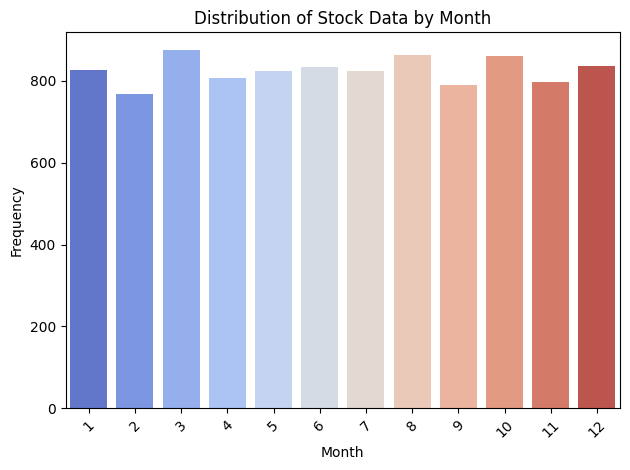

In [14]:
sns.countplot(x='Month', data=apple, palette='coolwarm')

plt.title('Distribution of Stock Data by Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# **Feature Engineering**

In [15]:
# Feature engineering: Adding moving averages and price changes
apple['MA50'] = apple['Close'].rolling(50).mean()
apple['MA200'] = apple['Close'].rolling(200).mean()
apple['Previous day close price'] = apple['Close'].shift(1)
apple['Change in price'] = apple['Close'] - apple['Previous day close price']
apple['Percent change in price'] = apple['Close'].pct_change()

In [16]:
# Check for missing values
apple.isnull().sum()

Date                          0
Open                          0
High                          0
Low                           0
Close                         0
Adj Close                     0
Volume                        0
Month                         0
MA50                         49
MA200                       199
Previous day close price      1
Change in price               1
Percent change in price       1
dtype: int64

In [17]:
apple.fillna(method='bfill', inplace=True)

In [18]:
apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month,MA50,MA200,Previous day close price,Change in price,Percent change in price
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400,12,0.530312,0.471596,0.513393,-0.026786,-0.052174
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200,12,0.530312,0.471596,0.513393,-0.026786,-0.052174
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000,12,0.530312,0.471596,0.486607,-0.035714,-0.073394
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400,12,0.530312,0.471596,0.450893,0.011161,0.024752
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400,12,0.530312,0.471596,0.462054,0.013393,0.028986


# **Data Preprocessing**

In [19]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(apple[['Close']])

In [20]:
# Function to create sequences (for single column data)
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [21]:
seq_length = 60  
X, y = create_sequences(scaled_data, seq_length)

X = X.reshape((X.shape[0], X.shape[1], 1))

In [20]:
# Reshape X for CNN and LSTM input
#X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

In [22]:
# Split data to train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# **CNN-LSTM Model**

In [23]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.4),
    LSTM(100),
    Dropout(0.4),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[reduce_lr])

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - loss: 1.9345e-04 - val_loss: 6.9446e-04 - learning_rate: 0.0010
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - loss: 3.8234e-05 - val_loss: 9.8809e-04 - learning_rate: 0.0010
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - loss: 6.3887e-05 - val_loss: 9.6777e-04 - learning_rate: 0.0010
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - loss: 3.7889e-05 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 4.1000e-05 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - loss: 3.7352e-05 - val_loss: 4.0453e-04 - learning_rate: 0.0010
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - loss: 3.9623e-05 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - loss: 3.4141e-05 - val_loss: 8.3492e-04 - learning_rate: 0.0010
Epoch 9/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/ste

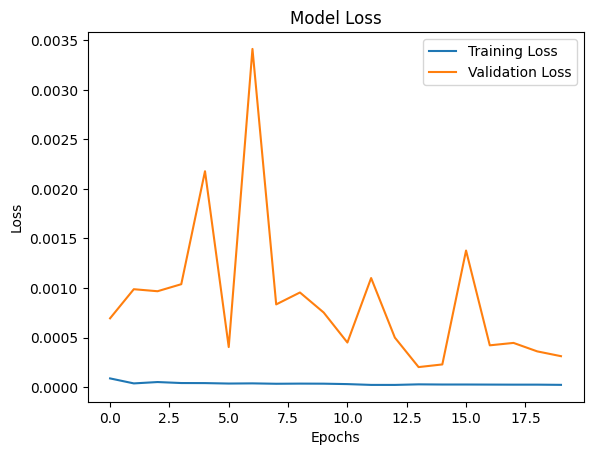

In [24]:
# Visualize the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# Make predictions on the test set
predicted_stock_price = model.predict(X_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


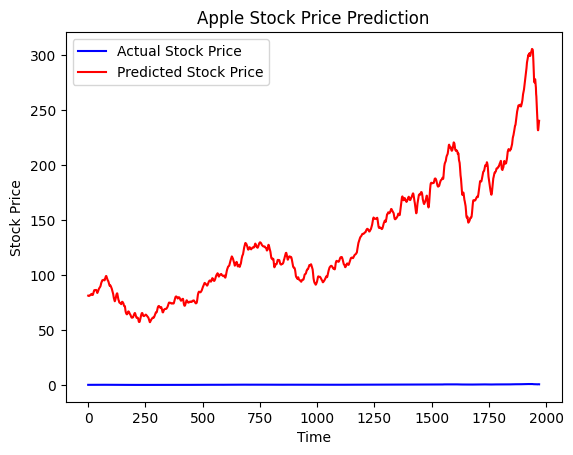

In [26]:
# Make predictions
predicted_stock_price = model.predict(X_test)

predicted_stock_price = scaler.inverse_transform(
    np.concatenate([predicted_stock_price, np.zeros((predicted_stock_price.shape[0], len(scaled_data)-1))], axis=1)
)[:, 0]

plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [27]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


In [28]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [29]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

15.967229948748297
142.49131631238163


In [29]:
'''original_scaled_data = scaler.inverse_transform(scaled_data)

plt.figure(figsize=(15, 6))

if original_scaled_data.shape[1] == 1:
    plt.plot(original_scaled_data[:, 0], color='black', label=f"Actual price")
else:
    plt.plot(original_scaled_data[:, 3], color='black', label=f"Actual price")

plt.plot(trainPredictPlot, color='red', label=f"Predicted apple price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted apple price (test set)")

plt.title("apple Share Price")
plt.xlabel("Time")
plt.ylabel("apple Share Price")
plt.legend()
plt.show()'''

'original_scaled_data = scaler.inverse_transform(scaled_data)\n\nplt.figure(figsize=(15, 6))\n\nif original_scaled_data.shape[1] == 1:\n    plt.plot(original_scaled_data[:, 0], color=\'black\', label=f"Actual price")\nelse:\n    plt.plot(original_scaled_data[:, 3], color=\'black\', label=f"Actual price")\n\nplt.plot(trainPredictPlot, color=\'red\', label=f"Predicted apple price (train set)")\nplt.plot(testPredictPlot, color=\'blue\', label=f"Predicted apple price (test set)")\n\nplt.title("apple Share Price")\nplt.xlabel("Time")\nplt.ylabel("apple Share Price")\nplt.legend()\nplt.show()'

In [30]:
original_scaled_data = scaler.inverse_transform(scaled_data)

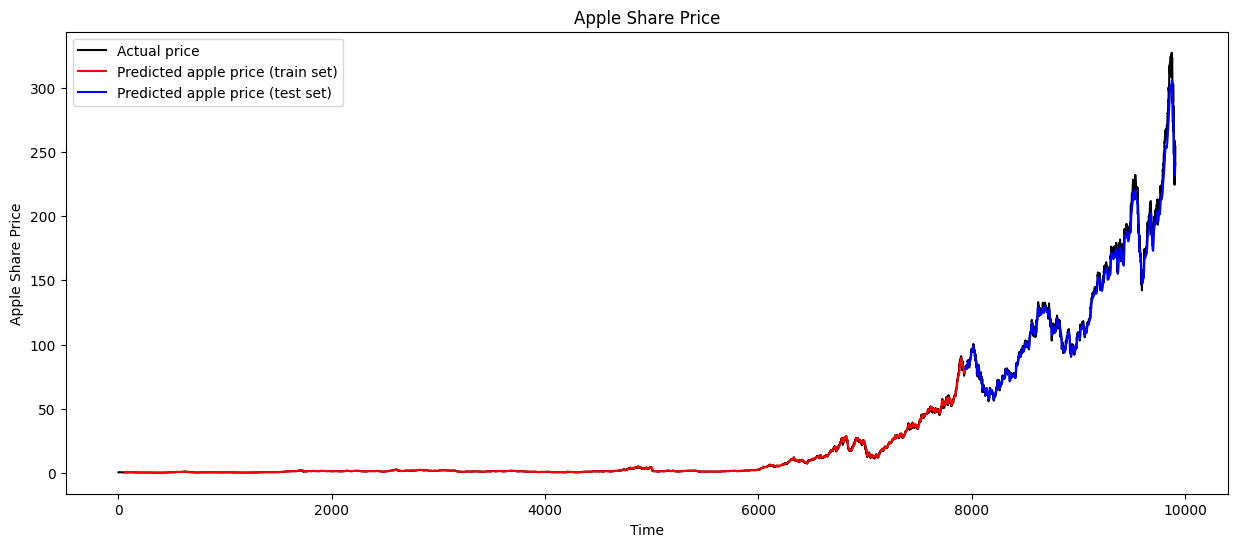

In [31]:
look_back = 60
trainPredictPlot = np.empty((len(original_scaled_data), 1))
trainPredictPlot[:] = np.nan

trainPredictPlot[look_back:look_back + len(train_predict)] = train_predict.reshape(-1, 1)

testPredictPlot = np.empty((len(original_scaled_data), 1))
testPredictPlot[:] = np.nan

test_start = len(original_scaled_data) - len(test_predict)
testPredictPlot[test_start:] = test_predict.reshape(-1, 1)


plt.figure(figsize=(15, 6))

if original_scaled_data.shape[1] == 1:
    plt.plot(original_scaled_data[:, 0], color='black', label="Actual price")
else:
    plt.plot(original_scaled_data[:, 3], color='black', label="Actual price")

plt.plot(trainPredictPlot, color='red', label="Predicted apple price (train set)")
plt.plot(testPredictPlot, color='blue', label="Predicted apple price (test set)")

plt.title("Apple Share Price")
plt.xlabel("Time")
plt.ylabel("Apple Share Price")
plt.legend()
# Save the figure before displaying
plt.savefig("apple share price.png", dpi=300, bbox_inches='tight')
plt.show()